# Exploring Langchain 

In [23]:
%pip install langchain openai tiktoken chromadb --quiet


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Asking Questions about Data

My first instinct is to check if arbitrary CSV data can be added to the embeddings in a way that the LLM model can "understand" it.

In [24]:
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

Download and save a random dataset.

In [31]:
import pandas as pd
df = pd.read_csv("https://datahub.io/core/natural-gas/r/daily.csv")
df.to_csv("../datasets/natural_gas.csv", index=False)

In [27]:
loader = CSVLoader(file_path="../datasets/natural_gas.csv")
data = loader.load()
csv_index = VectorstoreIndexCreator().from_loaders([loader])

In [29]:
chain = RetrievalQA.from_chain_type(
    llm=OpenAI(),
    chain_type="stuff",
    retriever=csv_index.vectorstore.as_retriever(),
    input_key="question",
)

That's it. Now, let's ask questions.

In [49]:
chain({"question": "What is the trend in Price?"})

{'question': 'What is the trend in Price?',
 'result': ' The price is remaining at 1.91, which indicates that the price is not increasing or decreasing.'}

<Axes: xlabel='Date'>

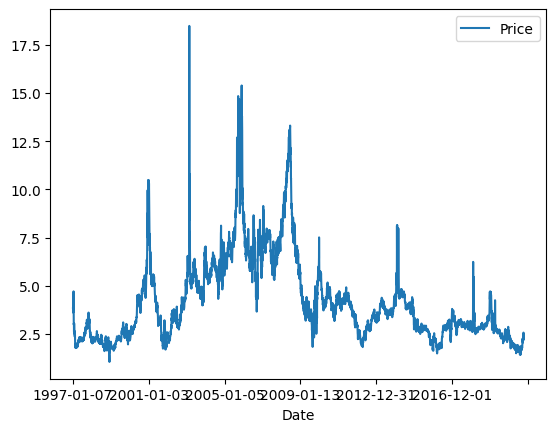

In [50]:
df.plot(x="Date", y="Price")

Pretty poor answer... Rerunning the cell with the same question gives a different answer. Let's try with an easier question.

In [33]:
chain({"question": "When was the maximum Price?"})

{'question': 'When was the maximum Price?',
 'result': ' The maximum Price was 2.45 on April 1, 1998.'}

In [38]:
df.sort_values(by="Price", ascending=False).head(5)

,Date,Price
1535,2003-02-25,18.48
2226,2005-12-13,15.39
2224,2005-12-09,15.02
2180,2005-09-22,14.84
2225,2005-12-12,14.82


Also clearly wrong. Seems is not able to grok the data. The proper approach is probably making the model generate the SQL/pandas code to run on top of the data. Let's try that.

In [51]:
from langchain.agents import create_csv_agent

In [52]:
agent = create_csv_agent(OpenAI(temperature=0), "../datasets/natural_gas.csv", verbose=True)

In [42]:
agent.run("how many rows are there?")



> Entering new AgentExecutor chain...
Thought: I need to count the rows
Action: python_repl_ast
Action Input: len(df)
Observation: 5953
Thought: I now know the final answer
Final Answer: 5953 rows

> Finished chain.


'5953 rows'

In [43]:
df.shape

(5953, 2)

Correct! It did run `len(df)` and got the correct answer. Let's try with more complex questions.

In [44]:
agent.run("When was the maximum Price?")



> Entering new AgentExecutor chain...
Thought: I need to find the maximum Price and the corresponding Date
Action: python_repl_ast
Action Input: df['Price'].max()
Observation: 18.48
Thought: I need to find the Date corresponding to the maximum Price
Action: python_repl_ast
Action Input: df.loc[df['Price'] == df['Price'].max(), 'Date']
Observation: 1535    2003-02-25
Name: Date, dtype: object
Thought: I now know the final answer
Final Answer: The maximum Price was on 2003-02-25.

> Finished chain.


'The maximum Price was on 2003-02-25.'



> Entering new AgentExecutor chain...
Thought: I need to look at the data to see the trend
Action: python_repl_ast
Action Input: df.plot(x='Date', y='Price')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I can see the trend in the graph
Final Answer: The trend in Price is increasing.

> Finished chain.


'The trend in Price is increasing.'

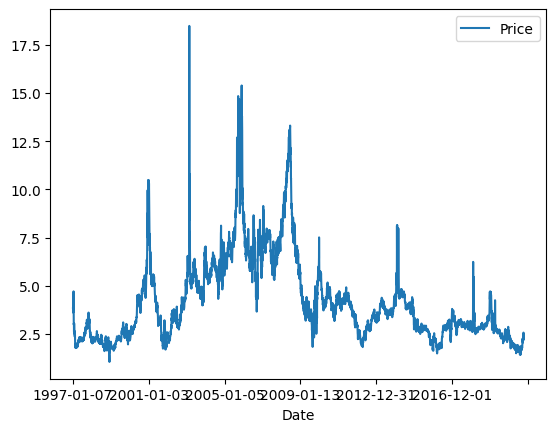

In [46]:
agent.run("What is the trend in Price")

It plotted the trend in Price but then replied with something random-ish? The question isn't super clear though.